# Data Analysis in Python; Inflation and Stock Market

Inflation has gotten worse in recent years: in June 2021, the CPI exceeded +5%. Initially thought to be transitory, inflation continued to rise, reaching +8.3% CPI in April of this year. The stock market is very volatile under such inflation. In this article, we will look back at historical data and discuss the relationship between inflation and stocks.

Throughout this article you will learn

1. how to obtain economic data

2. the relationship between inflation and stocks

3. how to draw complex graphs in python with a mixture of bar and line charts.

Reference:

Koki Noda, https://wire.insiderfinance.io/inflation-and-stock-market-61cbeeebaaf5


In [70]:
import os
import re
import datetime as dt
from concurrent import futures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from sklearn.linear_model import LinearRegression
data_dir = "./data/"
os.makedirs(data_dir, exist_ok=True)

## Download Dataset
The following three data sets will be used in this study. We will download them in order.

- S&P500 Index Historical Data
- CPI (annual)
- CPI (monthly)

## S&P500 Index Historical Data
We will get S&P500 historical data from Yahoo Finance. For more information, please check here. All available data is downloaded here.

In [71]:
# get historical data of S&P500(^GSPC) - due to mktime overflow error, we can't go below 1971 even if data is available uptill 1920
sp_500 = web.DataReader('^GSPC', 'yahoo', start='1971-01-01', end=dt.date.today())
print(sp_500.shape)
# save the data
sp500_file_path = f"{data_dir}/S&P500.csv"
sp_500.to_csv(sp500_file_path)
sp_500 = pd.read_csv(sp500_file_path, index_col="Date", parse_dates=True)
sp_500.head(3)

(12974, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1971-01-04,92.190002,90.639999,0.0,91.150002,10010000,91.150002
1971-01-05,92.279999,90.690002,0.0,91.800003,12600000,91.800003
1971-01-06,93.000000,91.500000,0.0,92.349998,16960000,92.349998


We will draw a time-series plot to see how prices have changed.

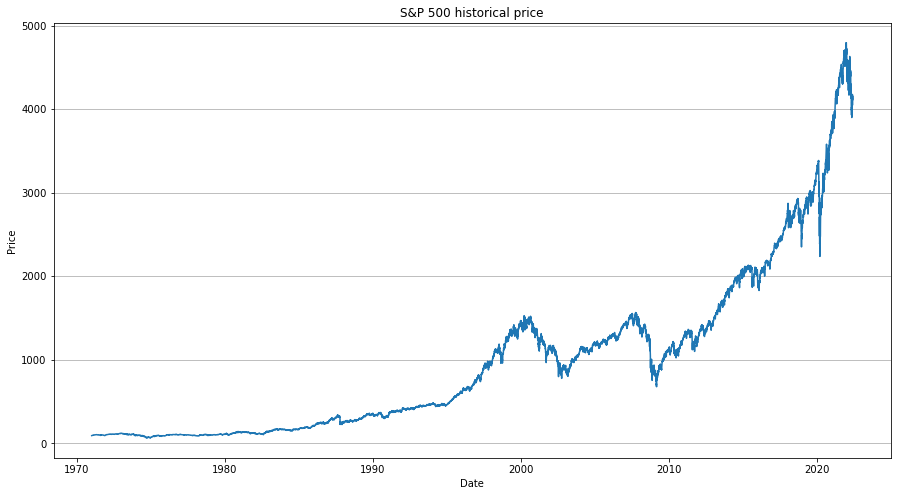

In [72]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(sp_500.index, sp_500["Close"])
ax.grid(axis="y")
ax.set_title("S&P 500 historical price")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
plt.show()

## CPI (annual)
CPI stands for Consumer Price Index and is one of the indicators that measure inflation.

CPI reflects the annual percentage change in the cost to the average consumer of acquiring a basket of goods and services that may be fixed or changed at specified intervals, such as yearly.

Note that this CPI is not seasonally adjusted.

Reference:

World Bank, Inflation, consumer prices for the United States [FPCPITOTLZGUSA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/FPCPITOTLZGUSA, May 12, 2022.

In [73]:
start = dt.datetime(1900, 1, 1)
end = dt.datetime.today()
cpi_annual = web.DataReader('FPCPITOTLZGUSA', 'fred', start, end)
# save the data
file_path = f"{data_dir}/FPCPITOTLZGUSA.csv"
cpi_annual.to_csv(file_path)
cpi_annual = pd.read_csv(file_path, index_col="DATE", parse_dates=True)
print(cpi_annual.shape)
cpi_annual.tail(3)

(62, 1)


,FPCPITOTLZGUSA
DATE,
2019-01-01,1.812210
2020-01-01,1.233584
2021-01-01,4.697859


We will draw a time-series plot to see how CPI have changed.

Text(0, 0.5, 'CPI change (%)')

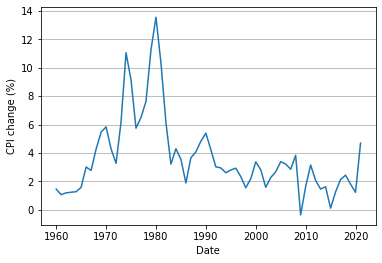

In [74]:
plt.plot(cpi_annual)
plt.grid(axis='y')
plt.xlabel("Date")
plt.ylabel("CPI change (%)")

CPI reached +4.7% in 2021. Inflation is even worse than that now.

Looking back at the past, there have been several phases of similarly bad inflation. In 1969 and 1970, the CPI exceeded 5%. Inflation then eased for a time, but inflation again became severe starting in 1973. Inflation then continued until 1982, with the CPI above 5% throughout that period. In the worst year (1980), it reached 13.5%.

Price inflation remained high from 1988 to 1990 or from 2005 to 2008.

## CPI (monthly)
Here we use data from the Consumer Price Index for All Urban Consumers: All Items (CPIAUCSL). This data is a price index of a basket of goods and services paid by urban consumers. Percent changes in the price index measure the inflation rate between any two time periods.

Note that this CPI is seasonally adjusted.

Reference:

U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items in U.S. City Average [CPIAUCSL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CPIAUCSL, May 12, 2022.

In [75]:
start = dt.datetime(1900, 1, 1)
end = dt.datetime.today()
cpi_monthly = web.DataReader('CPIAUCSL', 'fred', start, end)
# save the data
file_path = f"{data_dir}/CPIAUCSL.csv"
cpi_monthly.to_csv(file_path)
cpi_monthly = pd.read_csv(file_path, index_col="DATE", parse_dates=True)
print(cpi_monthly.shape)
cpi_monthly.tail(3)

(904, 1)


,CPIAUCSL
DATE,
2022-02-01,284.182
2022-03-01,287.708
2022-04-01,288.663


We will draw a time-series plot to see how CPI have changed.

This data has not yet been converted to rate of change, so the curve is a gradual increase as shown below.

Text(0, 0.5, 'CPI (%)')

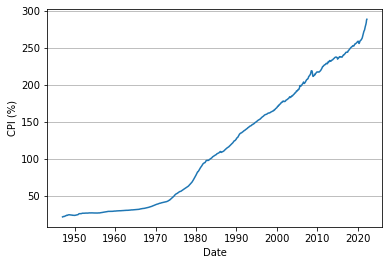

In [76]:
plt.plot(cpi_monthly)
plt.grid(axis='y')
plt.xlabel("Date")
plt.ylabel("CPI (%)")

The CPI is usually converted to a rate of change since the most common inflation metric is the percent change from one year ago.

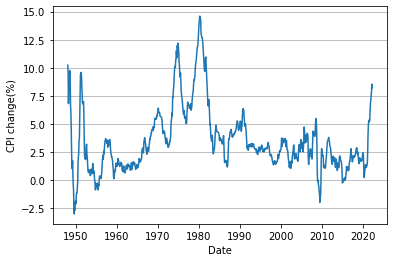

In [77]:
cpi_monthly_change = cpi_monthly / cpi_monthly.shift(12) * 100 - 100
plt.plot(cpi_monthly_change)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("CPI change(%)")
plt.show()

It can be seen that the line graph is similar to the annual data.

## CPI vs. S&P 500 Annual Returns

Let’s analyze the relationship between inflation and the S&P 500 Index. Since we want to compare values for each year, the S&P500 data will be used to calculate the average annual performance. The performance is calculated as the percent change from the last trading day of each year from the last trading day of the previous year.

In [78]:
annual_data_list = []
year_list = sp_500.index.year.unique()
for year in year_list:
    last_day_data = sp_500[sp_500.index.year == year].tail(1)
    annual_data_list.append(last_day_data)
sp500_annual = pd.concat(annual_data_list)

sp500_annual_performance = sp500_annual[["Close"]] / sp500_annual[["Close"]].shift(1) * 100 - 100
sp500_annual_performance.index = pd.to_datetime(sp500_annual_performance.index.strftime("%Y"))  # reset index to YYYY-01-01
sp500_annual_performance.tail()

,Close
Date,
2018-01-01,-6.237260
2019-01-01,28.878070
2020-01-01,16.258923
2021-01-01,26.892739
2022-01-01,-14.899565


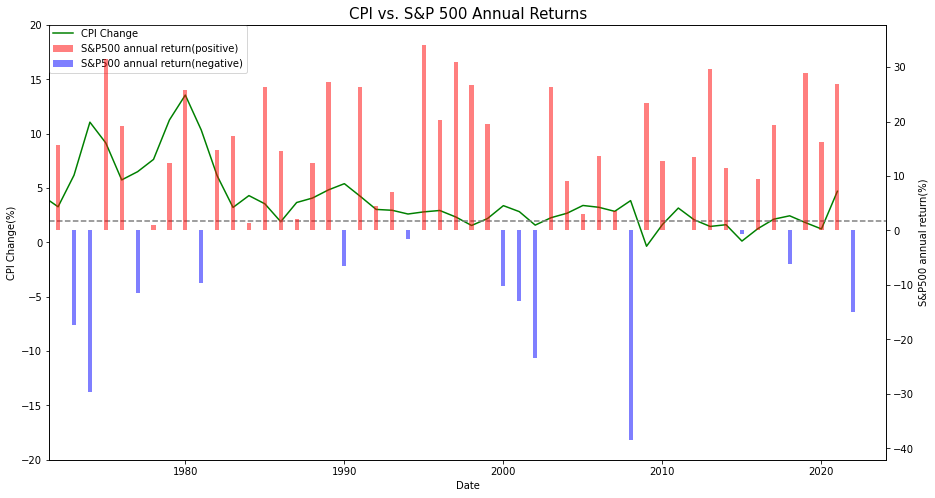

In [79]:
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()

ax1.plot(cpi_annual.index, cpi_annual,
         color="green", label="CPI Change")
sp500_annual_performance_plus = sp500_annual_performance[sp500_annual_performance >= 0]
ax2.bar(sp500_annual_performance_plus.index, sp500_annual_performance_plus["Close"],
        color="red", alpha=0.5, width=5000 / len(sp500_annual_performance_plus), label="S&P500 annual return(positive)")

sp500_annual_performance_minus = sp500_annual_performance[sp500_annual_performance < 0]
ax2.bar(sp500_annual_performance_minus.index, sp500_annual_performance_minus["Close"],
        color="blue", alpha=0.5, width=5000 / len(sp500_annual_performance_minus), label="S&P500 annual return(negative)")

ax1.axhline(2, color='gray', linestyle='--')

plt.tick_params(labelsize=10)  # font size of tick labels

plt.title("CPI vs. S&P 500 Annual Returns", fontsize=15)

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

ax1.set_xlabel("Date")
ax1.set_ylabel("CPI Change(%)")
ax2.set_ylabel("S&P500 annual return(%)")
ax1.set_ylim([-20, 20])
ax1.set_xlim([min(sp500_annual.index) - dt.timedelta(days=200),
              max(sp500_annual.index) + dt.timedelta(days=600)])
plt.show()

Great, on one graph we were able to draw the change in CPI as a line graph and the performance of the S&P 500 as a bar graph. In addition, we color coded the stock performance in red when it was positive and in blue when it was negative.

Although it appears that blue bars appear when inflation is bad, red bars are also present; to see the relationship between CPI and stock performance, let’s draw a scatter plot with both on the axis.

1972-01-01     3.272278
1973-01-01     6.177760
1974-01-01    11.054805
1975-01-01     9.143147
1976-01-01     5.744813
1977-01-01     6.501684
1978-01-01     7.630964
1979-01-01    11.254471
1980-01-01    13.549202
1981-01-01    10.334715
1982-01-01     6.131427
1983-01-01     3.212435
1984-01-01     4.300535
1985-01-01     3.545644
1986-01-01     1.898048
1987-01-01     3.664563
1988-01-01     4.077741
1989-01-01     4.827003
1990-01-01     5.397956
1991-01-01     4.234964
1992-01-01     3.028820
1993-01-01     2.951657
1994-01-01     2.607442
1995-01-01     2.805420
1996-01-01     2.931204
1997-01-01     2.337690
1998-01-01     1.552279
1999-01-01     2.188027
2000-01-01     3.376857
2001-01-01     2.826171
2002-01-01     1.586032
2003-01-01     2.270095
2004-01-01     2.677237
2005-01-01     3.392747
2006-01-01     3.225944
2007-01-01     2.852672
2008-01-01     3.839100
2009-01-01    -0.355546
2010-01-01     1.640043
2011-01-01     3.156842
2012-01-01     2.069337
2013-01-01     1

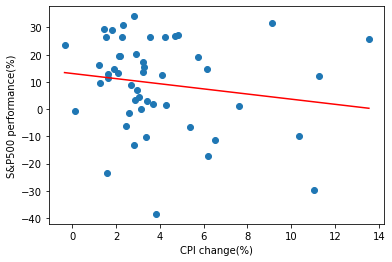

In [83]:
merge_df = pd.merge(cpi_annual, sp500_annual_performance.dropna(), left_index=True, right_index=True)
merge_df.rename(columns={"FPCPITOTLZGUSA": "CPI", "Close": "SP500"}, inplace=True)

model = LinearRegression()
model_reg = model.fit(merge_df[["CPI"]], merge_df["SP500"])

reg_curve_x = np.linspace(min(merge_df["CPI"]), max(merge_df["CPI"]))
reg_curve_y = model_reg.predict(reg_curve_x.reshape(-1, 1))

plt.scatter(merge_df["CPI"], merge_df["SP500"])
plt.plot(reg_curve_x, reg_curve_y, color="red")
plt.xlabel("CPI change(%)")
plt.ylabel("S&P500 performance(%)")
plt.show()

A red regression line has been added to make the correlation easier to understand. The trend seems to be that the larger the rate of price increase, the worse the S&P 500 performs. However, this is not necessarily true, and some y values are high even when the x-axis is large. As can be seen from the graph above, the data points are quite discretely distributed.

## CPI vs. S&P 500 Monthly Returns
The same thing done above can be done with monthly data.

In [84]:
monthly_data_list = []
month_list = sorted(sp_500.index.month.unique())
for year in year_list:
    for month in month_list:
        last_day_data = sp_500[(sp_500.index.year == year) & (sp_500.index.month == month)].tail(1)
        monthly_data_list.append(last_day_data)
sp500_monthly = pd.concat(monthly_data_list)
sp500_monthly_performance = sp500_monthly[["Close"]] / sp500_monthly[["Close"]].shift(1) * 100 - 100
sp500_monthly_performance.index = pd.to_datetime(
    sp500_monthly_performance.index.strftime("%Y-%m"))  # reset index to YYYY-01-01
sp500_monthly_performance.tail()

,Close
Date,
2022-02-01,-3.136049
2022-03-01,3.577329
2022-04-01,-8.795671
2022-05-01,0.005318
2022-06-01,-1.841895


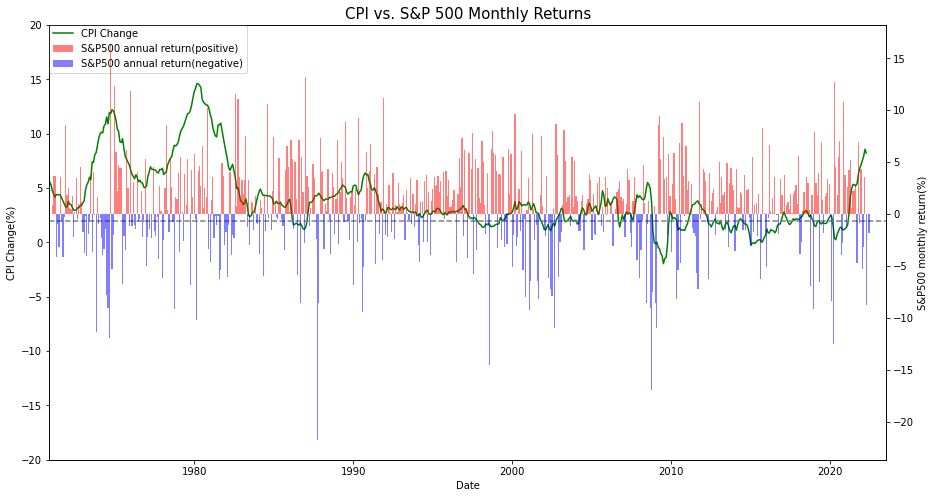

In [86]:
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()
ax1.plot(cpi_monthly_change.index, cpi_monthly_change,
         color="green", label="CPI Change")
sp500_monthly_performance_plus = sp500_monthly_performance[sp500_monthly_performance >= 0]
ax2.bar(sp500_monthly_performance_plus.index, sp500_monthly_performance_plus["Close"],
        color="red", alpha=0.5, width=17000 / len(sp500_monthly_performance_plus), label="S&P500 annual return(positive)")
sp500_monthly_performance_minus = sp500_monthly_performance[sp500_monthly_performance < 0]
ax2.bar(sp500_monthly_performance_minus.index, sp500_monthly_performance_minus["Close"],
        color="blue", alpha=0.5, width=17000 / len(sp500_monthly_performance_minus), label="S&P500 annual return(negative)")
ax1.axhline(2, color='gray', linestyle='--')
plt.tick_params(labelsize=10)  # font size of tick labels
plt.title("CPI vs. S&P 500 Monthly Returns", fontsize=15)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI Change(%)")
ax2.set_ylabel("S&P500 monthly return(%)")
ax1.set_ylim([-20, 20])
ax1.set_xlim([min(sp500_monthly_performance.index) - dt.timedelta(days=40),
              max(sp500_monthly_performance.index) + dt.timedelta(days=400)])
plt.show()


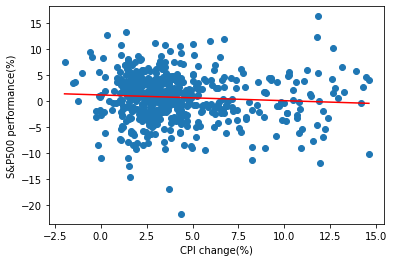

In [89]:
merge_df_monthly = pd.merge(cpi_monthly_change, sp500_monthly_performance.dropna(), left_index=True, right_index=True)
merge_df_monthly.rename(columns={"CPIAUCSL": "CPI", "Close": "SP500"}, inplace=True)

model_monthly = LinearRegression()
model_monthly_reg = model_monthly.fit(merge_df_monthly[["CPI"]], merge_df_monthly["SP500"])

reg_curve_monthly_x = np.linspace(min(merge_df_monthly["CPI"]), max(merge_df_monthly["CPI"]))
reg_curve_monthly_y = model_monthly_reg.predict(reg_curve_monthly_x.reshape(-1, 1))

plt.scatter(merge_df_monthly["CPI"], merge_df_monthly["SP500"])
plt.plot(reg_curve_monthly_x, reg_curve_monthly_y, color="red")
plt.xlabel("CPI change(%)")
plt.ylabel("S&P500 performance(%)")
plt.show()

# Conclusion
__When prices are rising above 2% and inflation is high, it does not necessarily mean that stock price performance is poor.__ However, it is important to note that the market can collapse significantly under inflation.